In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
import tf_memory_limit
#import matplotlib; matplotlib.use('Agg')  # Must be before importing matplotlib.pyplot or before importing pylab!
from keras import backend as K
import tensorflow as tf
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model, Model
from keras.layers import Input, Activation
import viz_sequence
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import correlate2d
from scipy.special import logit

colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

batch_size=32
input_window=256

# load the strength model
model_path = '/home/kal/CTCF/mass_CTCF/output/strength/20171128_132105/20171128_132105_weights_3_247_45227.62.hdf5'
gen_path='/home/kal/data/ctcf_strengthgen.hdf5'

#layer_name = 'conv1d_3'
#filter_index = 2 # can be anything from 0 to 7 - this convolution had 8 filters

Using TensorFlow backend.


In [18]:
# load the model
model = load_model(model_path, custom_objects={'Bias':Bias})

# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)

# get the symbolic outputs of each "key" layer.
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print(layer_dict.keys())

# get the motifs as sequences
def get_sequence(meme):
    bases = np.argmax(meme, axis=1)
    pwm = np.zeros((bases.shape[0], 4))
    for base, i in zip(pwm, bases):
        base[i] = 1 
    return pwm
ctcf_seqs = [get_sequence(meme) for meme in ctcfgen.CTCF_memes]
mystery_seqs = [get_sequence(meme) for meme in ctcfgen.mystery_memes]

dict_keys(['bias', 'lambda_1', 'spatial_dropout1d_4', 'spatial_dropout1d_1', 'conv1d_1', 'spatial_dropout1d_3', 'wide_scan', 'spatial_dropout1d_2', 'final_conv', 'input_1', 'stackmax', 'conv1d_4', 'conv1d_2', 'conv1d_3'])


In [19]:
# helper functions
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def rejection(seq_a, seq_b):
    """utiliy function to compute rejection of a from b"""
    out = list()
    for a, b in zip(seq_a, seq_b):
        if np.linalg.norm(b) == 0:
            out.append(a)
        else:
            out.append(a - ((np.dot(a, b) / (np.linalg.norm(b)**2)) * b))
    return np.asarray(out)

def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [20]:
def seq_from_distribution(distribution):
    seq = []
    one_hots = ctcfgen.encode(np.fromstring('acgt', np.uint8))
    for base in distribution:
        idx = np.random.choice(range(4), p=base)
        seq.append(one_hots[idx])
    return np.asarray(seq)

In [21]:
def build_iterate(model, filter_index, layer_name):
    
    # set a placeholder input
    encoded_seq = model.input

    # build a function that maximizes the activation of the nth filter of the layer considered
    if layer_name == 'final_output':
        activations = model.output

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(activations), encoded_seq)[0]

    else:
        layer_output = layer_dict[layer_name].output

        activations = layer_output[:, :, filter_index]
        combined_activation = max(activations[:32], activations[32:]) # we only generate forward sequences anyway

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(K.sum(K.max(combined_activation, axis=1)), encoded_seq)[0]

    # normalization trick: we normalize the gradient
    # grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([encoded_seq, K.learning_phase()], [activations, grads])
    
    return iterate

In [22]:
def rand_seq_gen(size):
    while True:
        random = np.random.choice(np.fromstring('acgt', np.uint8), size=size)
        yield ctcfgen.encode(random).astype(np.float)
r = rand_seq_gen(256)

In [37]:
def dream(seq, iterate, n=20, orig=False, seq_center=0, verb=0):

    # get benchmark sequences
    orig_seq = seq
    
    # get a batch generator 
    def get_seq(start_seq):
        while True:
            yield seq_from_distribution(start_seq)
    batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
    
    # find an appropriate step size
    activations, grads = iterate([next(batch_gen), 0])
    max_grad = np.amax(grads)
    step = 8/(max_grad)
    
    if seq_center == 1:
        seq_center = np.argmax(np.amax(np.average(grads, axis=0), axis=1))
        print(seq_center)
    
    if verb > 1:
        plot_partial_dream(seq, seq_center, activations, 0) 
                
    if orig:
        #take an inital step
        seq = softmax([seq+np.average(grads, axis=0)*step])[0]
        print('First step')
        viz_sequence.plot_weights(seq)
        
    for i in range(n):
        # get some sequences
        batch_gen = ctcfgen.filled_batch(get_seq(seq), batch_size=32)
        input_seqs = next(batch_gen)
        # get the gradients 
        activations, grads = iterate([input_seqs, 0])
        
        #check changes are still made
        if (np.amax(grads) == .1):
            if verb != 0:
                print('sequence after '+ str(i+1) + ' iterations')
                viz_sequence.plot_weights(seq)
                print('Nothing is happening')
            break
            
        # update the sequence
        if orig:
            update = np.average(grads, axis=0)
            seq = np.log(seq) + update*step
        else:
            update = grads * input_seqs
            update = np.average(update, axis=0) * seq        
        
            seq = np.log(seq) + update*step - seq*.05
        seq = softmax([seq])[0] 
        
        #print some stuff
        if i % 10 == 0 and verb > 1:
            plot_partial_dream(seq, seq_center, activations, i, plot_update=True, update=update)            
        
    if verb > 0:
        plot_partial_dream(seq, seq_center, activations, i) 
    return seq

def plot_partial_dream(seq, seq_center, activations, i, plot_update=False, update=None):
    print('sequence after '+ str(i+1) + ' iterations @ activation ' + str(sum(activations)/len(activations)))
    if seq_center>0:
        viz_sequence.plot_icweights(seq[seq_center-40:seq_center+40])
    else:
        viz_sequence.plot_icweights(seq)
    if plot_update:
        print('gradients')
        if seq_center>0:
            viz_sequence.plot_weights(update[seq_center-40:seq_center+40])
        else:
            viz_sequence.plot_weights(update)

Layer: final_output , Filter: 0


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in log


sequence after 50 iterations @ activation[ 1600.53540039]


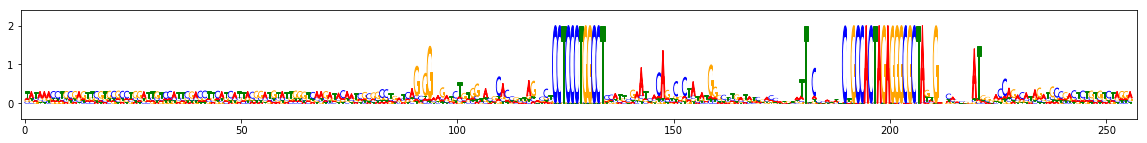

In [60]:
layer_name = 'final_output'
i=0
mystery_start = (256 - mystery_seqs[0].shape[0])//2

# get the specific filter within this layer we are looking at
print('Layer: ' + layer_name + ' , Filter: ' + str(i))

#build the iteration model
iterate = build_iterate(model, i, layer_name)
    
#find high scoring sequences
plain_seq = next(r)
#seq[mystery_start:mystery_start+mystery_seqs[0].shape[0]] = next(rand_seq_gen(mystery_seqs[0].shape[0]))  #insert motif
seq = plain_seq*.8 + .05
seq[mystery_start:mystery_start+mystery_seqs[0].shape[0]] = mystery_seqs[0]
#seq = plain_seq*.6 + .1
orig_seq = seq

# dream the sequences
seq = dream(seq, iterate, seq_center=0, verb=1, n=50)

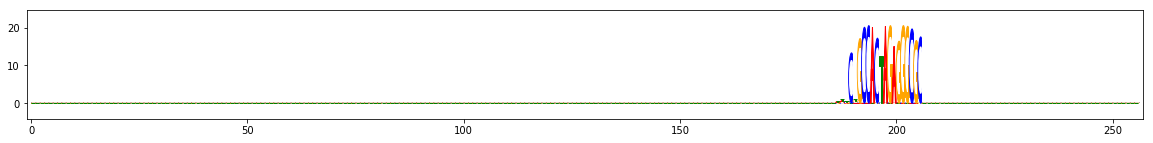

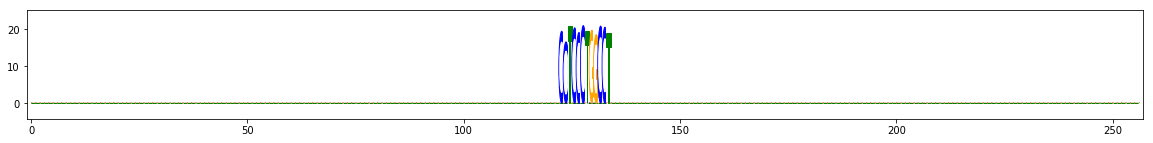

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [61]:
# scan the new sequence and old sequence with position weight matricies
filler = np.zeros((256, 4))

#find ctcf
score, pwm, meme, meme_index, position = ctcfgen.get_pwm([seq], get_everything=True)
viz_sequence.plot_icweights(pwm)

#find mystery 
score, pwm, meme, meme_index, position = ctcfgen.get_pwm([seq], meme_library='mystery_memes', get_everything=True)
viz_sequence.plot_icweights(pwm)